In [ ]:
!pip install kaggle
!kaggle datasets download -d "decide-soluciones/air-quality-madrid"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 96% 152M/158M [00:00<00:00, 173MB/s]
100% 158M/158M [00:00<00:00, 171MB/s]


In [ ]:
!unzip air-quality-madrid.zip -d csvs_per_year/

Archive:  air-quality-madrid.zip
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2001.csv  
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2002.csv  
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2003.csv  
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2004.csv  
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2005.csv  
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2006.csv  
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2007.csv  
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2008.csv  
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2009.csv  
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2010.csv  
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2011.csv  
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2012.csv  
  inflating: csvs_per_year/csvs_per_year/csvs_per_year/madrid_2013.csv  
  inflating: csvs_

In [ ]:
#We'll be using the sktime package for plotting, which is currently not available on this platform.
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 65.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import glob
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.utils.plotting import plot_series
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from numpy import log
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
#Using the glob package to read all files with datatype csv contained in the folder
files = glob.glob("csvs_per_year/csvs_per_year/csvs_per_year**/*.csv")

df = pd.DataFrame()
for f in files:
    csv = pd.read_csv(f)
    df = df.append(csv)

<ipython-input-15-4ee037a34708>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(csv)
<ipython-input-15-4ee037a34708>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(csv)
<ipython-input-15-4ee037a34708>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(csv)
<ipython-input-15-4ee037a34708>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(csv)
<ipython-input-15-4ee037a34708>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(csv)
<ipython-input-15-4ee037a34708>:7: FutureWarning: 

In [ ]:
df.head()

,date,BEN,CH4,CO,EBE,NMHC,NO,NO_2,NOx,O_3,PM10,PM25,SO_2,TCH,TOL,station,MXY,OXY,PXY
0,2018-03-01 01:00:00,NaN,NaN,0.3,NaN,NaN,1.0,29.0,31.0,NaN,NaN,NaN,2.0,NaN,NaN,28079004,NaN,NaN,NaN
1,2018-03-01 01:00:00,0.5,1.39,0.3,0.2,0.02,6.0,40.0,49.0,52.0,5.0,4.0,3.0,1.41,0.8,28079008,NaN,NaN,NaN
2,2018-03-01 01:00:00,0.4,NaN,NaN,0.2,NaN,4.0,41.0,47.0,NaN,NaN,NaN,NaN,NaN,1.1,28079011,NaN,NaN,NaN
3,2018-03-01 01:00:00,NaN,NaN,0.3,NaN,NaN,1.0,35.0,37.0,54.0,NaN,NaN,NaN,NaN,NaN,28079016,NaN,NaN,NaN
4,2018-03-01 01:00:00,NaN,NaN,NaN,NaN,NaN,1.0,27.0,29.0,49.0,NaN,NaN,3.0,NaN,NaN,28079017,NaN,NaN,NaN


# Data Preprocessing

In [ ]:
df.dtypes

date        object
BEN        float64
CH4        float64
CO         float64
EBE        float64
NMHC       float64
NO         float64
NO_2       float64
NOx        float64
O_3        float64
PM10       float64
PM25       float64
SO_2       float64
TCH        float64
TOL        float64
station      int64
MXY        float64
OXY        float64
PXY        float64
dtype: object

In [ ]:
df.describe()

,BEN,CH4,CO,EBE,NMHC,NO,NO_2,NOx,O_3,PM10,PM25,SO_2,TCH,TOL,station,MXY,OXY,PXY
count,1.041684e+06,14850.000000,2.651012e+06,1.001724e+06,1.085312e+06,1.532397e+06,3.787050e+06,2.376275e+06,2.991732e+06,2.861255e+06,816424.000000,2.775960e+06,1.086441e+06,1.038929e+06,3.808224e+06,315415.000000,315695.000000,315584.000000
mean,1.257431e+00,1.300849,5.503838e-01,1.407927e+00,1.873865e-01,2.343886e+01,5.047151e+01,1.093188e+02,3.982616e+01,2.893654e+01,13.738292,1.065539e+01,1.435882e+00,5.876842e+00,2.807903e+07,4.650394,2.280912,2.056178
std,1.910831e+00,0.195550,5.354483e-01,2.146109e+00,1.539529e-01,5.021504e+01,3.455288e+01,1.102871e+02,3.039249e+01,2.594859e+01,11.214146,9.121267e+00,2.332228e-01,8.524460e+00,2.028574e+01,5.599223,2.639609,2.395130
min,0.000000e+00,0.020000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-31.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.807900e+07,0.000000,0.000000,0.000000
25%,2.100000e-01,1.170000,2.600000e-01,3.500000e-01,9.000000e-02,2.000000e+00,2.400000e+01,4.000000e+01,1.271000e+01,1.150000e+01,6.450000,5.840000e+00,1.300000e+00,1.100000e+00,2.807901e+07,1.200000,0.960000,0.800000
50%,6.000000e-01,1.250000,4.000000e-01,8.800000e-01,1.500000e-01,6.000000e+00,4.400000e+01,7.615000e+01,3.486000e+01,2.149000e+01,11.000000,8.150000e+00,1.380000e+00,3.160000e+00,2.807902e+07,2.800000,1.320000,1.280000
75%,1.500000e+00,1.400000,6.500000e-01,1.580000e+00,2.400000e-01,2.000000e+01,6.958000e+01,1.397000e+02,5.999000e+01,3.775000e+01,17.670000,1.230000e+01,1.510000e+00,6.990000e+00,2.807904e+07,5.890000,2.740000,2.510000
max,6.639000e+01,3.920000,1.804000e+01,1.622000e+02,9.070000e+00,1.146000e+03,6.286000e+02,2.537000e+03,2.360000e+02,6.950000e+02,506.899994,1.991000e+02,1.048000e+01,2.429000e+02,2.807910e+07,177.600006,103.000000,106.000000


In [ ]:
#date shouldn't be an onject dtype, change to datetime
df['date'] = pd.to_datetime(df.date, infer_datetime_format = True)

CO, TCH and CH4 are measured in mgm-3. We need to convert this to μgm-3.

In [ ]:
#Divide columns by 1000 to get desired unit
df['CO'] = df['CO']/1000
df['TCH'] = df['TCH']/1000
df['CH4'] = df['CH4']/1000

## Null Value Treatment

In [ ]:
df.isnull().sum()

date             0
BEN        2766540
CH4        3793374
CO         1157212
EBE        2806500
NMHC       2722912
NO         2275827
NO_2         21174
NOx        1431949
O_3         816492
PM10        946969
PM25       2991800
SO_2       1032264
TCH        2721783
TOL        2769295
station          0
MXY        3492809
OXY        3492529
PXY        3492640
dtype: int64

Because there are different stations contained in this dataset, treating null values on the main dataset could lead to wrong interpretation of data. Let's break the data down into groups by using their station codes.

In [ ]:
df_stations = df.groupby('station')
data = df_stations.get_group(28079024)
data.index = data.date
data = data.drop(['date'], axis = 1)
data.head()

,BEN,CH4,CO,EBE,NMHC,NO,NO_2,NOx,O_3,PM10,PM25,SO_2,TCH,TOL,station,MXY,OXY,PXY
date,,,,,,,,,,,,,,,,,,
2018-03-01 01:00:00,0.4,0.00111,0.0002,0.1,0.06,1.0,25.0,27.0,55.0,5.0,4.0,4.0,0.00116,1.4,28079024,NaN,NaN,NaN
2018-03-01 02:00:00,0.3,0.00110,0.0002,0.1,0.05,1.0,12.0,13.0,69.0,5.0,4.0,4.0,0.00114,0.8,28079024,NaN,NaN,NaN
2018-03-01 03:00:00,0.3,0.00111,0.0001,0.1,0.05,1.0,12.0,13.0,65.0,6.0,5.0,4.0,0.00116,1.0,28079024,NaN,NaN,NaN
2018-03-01 04:00:00,0.4,0.00116,0.0001,0.2,0.05,1.0,8.0,10.0,64.0,4.0,3.0,4.0,0.00121,1.1,28079024,NaN,NaN,NaN
2018-03-01 05:00:00,0.3,0.00109,0.0001,0.1,0.05,1.0,9.0,11.0,63.0,4.0,3.0,4.0,0.00114,1.0,28079024,NaN,NaN,NaN


In [ ]:
data.shape

(151416, 18)

# Missing Value Treatment

In [ ]:
data.isnull().sum()/151416 * 100

BEN         8.919797
CH4        96.756618
CO          1.081127
EBE        11.659270
NMHC        1.944312
NO         58.006419
NO_2        1.079146
NOx        39.737544
O_3         1.506446
PM10        1.557299
PM25       19.554737
SO_2        1.045464
TCH         1.911291
TOL         8.927722
station     0.000000
MXY        52.230279
OXY        52.230279
PXY        52.229619
dtype: float64

Here, we can see so many columns that have way more values as null than those that actually have recorded values. Let's drop them to avoid bias when treating null values.

In [ ]:
data = data.drop(['MXY', 'OXY', 'PXY', 'NO', 'CH4', 'station'], axis = 1)

In [ ]:
data.skew()

BEN      8.850090
CO       2.098004
EBE     11.806298
NMHC     1.627515
NO_2     1.400706
NOx      2.535055
O_3      0.410557
PM10     2.645797
PM25     2.017436
SO_2     2.178624
TCH      3.163313
TOL      4.787562
dtype: float64

With skewness, any column with a value less than or equal to 0.5 can have its null values imputed with the mean of the column. All others can be median.

In [ ]:
data['O_3'].fillna(data['O_3'].mean(), inplace = True)
data['CO'].fillna(data['CO'].median(), inplace = True)
data['NMHC'].fillna(data['NMHC'].median(), inplace = True)
data['NO_2'].fillna(data['NO_2'].median(), inplace = True)
data['PM10'].fillna(data['PM10'].median(), inplace = True)
data['SO_2'].fillna(data['SO_2'].median(), inplace = True)
data['TCH'].fillna(data['TCH'].median(), inplace = True)

In [ ]:
# Define MICE Imputer and fill missing values for all other columns
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

data_imputed = pd.DataFrame(mice_imputer.fit_transform(data), columns=data.columns, index = data.index)

/usr/local/lib/python3.9/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
data_imputed.head()

,BEN,CO,EBE,NMHC,NO_2,NOx,O_3,PM10,PM25,SO_2,TCH,TOL
date,,,,,,,,,,,,
2018-03-01 01:00:00,0.4,0.0002,0.1,0.06,25.0,27.0,55.0,5.0,4.0,4.0,0.00116,1.4
2018-03-01 02:00:00,0.3,0.0002,0.1,0.05,12.0,13.0,69.0,5.0,4.0,4.0,0.00114,0.8
2018-03-01 03:00:00,0.3,0.0001,0.1,0.05,12.0,13.0,65.0,6.0,5.0,4.0,0.00116,1.0
2018-03-01 04:00:00,0.4,0.0001,0.2,0.05,8.0,10.0,64.0,4.0,3.0,4.0,0.00121,1.1
2018-03-01 05:00:00,0.3,0.0001,0.1,0.05,9.0,11.0,63.0,4.0,3.0,4.0,0.00114,1.0


In [ ]:
#Checking stationarity of data
result = adfuller(data_imputed['CO'].values)
print('p-value: %f' % result[1])

p-value: 0.000000


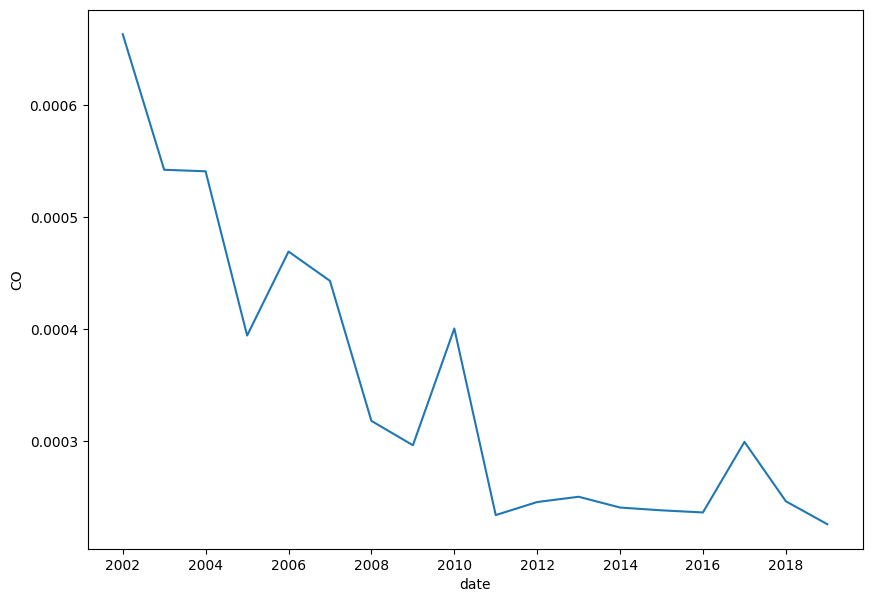

In [ ]:
#Resample by year to get a yearly trend of Carbon Monoxide levels
yearly_campo = data.resample("Y").mean()
plt.figure(figsize = (10, 7))
sns.lineplot(data = yearly_campo, x = yearly_campo.index, y = "CO")
plt.show()

# Resampling, Visualization and Modeling

To get a more detailed sense of the data, I will be resampling the data into different categories.

In [ ]:
#Get the mean of values in the dataset on a weekly basis
weekly_data = data_imputed.resample("W").mean()
weekly_data.head()

,BEN,CO,EBE,NMHC,NO_2,NOx,O_3,PM10,PM25,SO_2,TCH,TOL
date,,,,,,,,,,,,
2001-01-07,0.300778,0.000609,0.634709,0.101257,22.724072,29.141138,32.513593,11.161497,7.111696,8.999102,0.001360,2.664012
2001-01-14,0.723155,0.000895,1.505188,0.190833,50.246667,96.241250,13.021190,24.191012,13.771030,15.050119,0.001530,9.041607
2001-01-21,0.359709,0.000765,0.809573,0.144464,31.454524,59.776762,22.960567,18.602143,10.989644,11.679345,0.001447,4.085045
2001-01-28,0.245893,0.000602,0.520044,0.104405,19.118274,32.080833,34.955595,11.409762,7.793673,9.036905,0.001362,1.797560
2001-02-04,0.527911,0.000896,1.107875,0.199107,46.180714,100.565164,18.813333,27.269583,15.449894,16.739048,0.001536,5.555465


(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='Date', ylabel='Levls of Carbon Monoxide (μgm-3) '>)

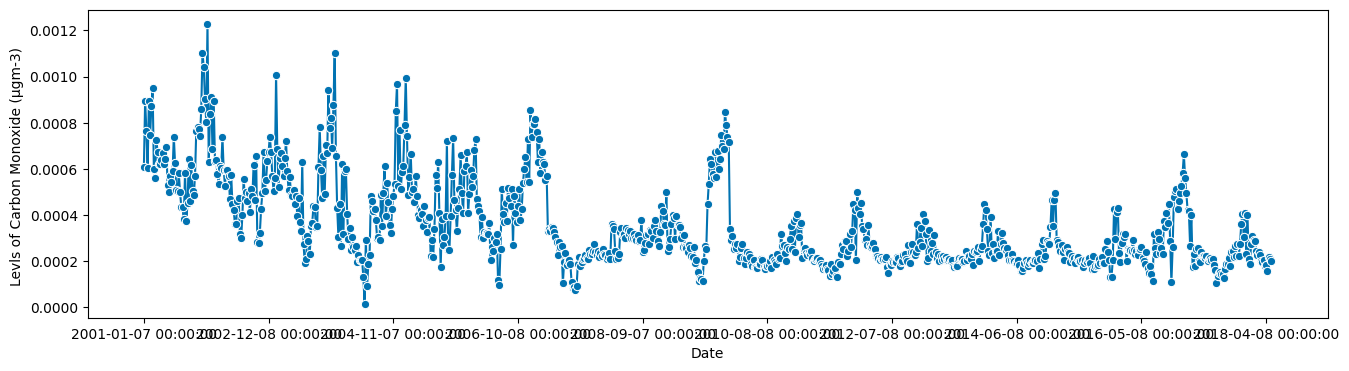

In [ ]:
plot_series(weekly_data['CO'], x_label = 'Date', y_label = 'Levls of Carbon Monoxide (μgm-3) ')

We can see that Carbon Monoxide levels were consistently high before 2007, before largely maintaining values below 0.004.

In [ ]:
weekly_data['CO'].idxmax()

Timestamp('2001-12-30 00:00:00', freq='W-SUN')

In [ ]:
weekly_data['CO'].max()

0.0012289880927474725

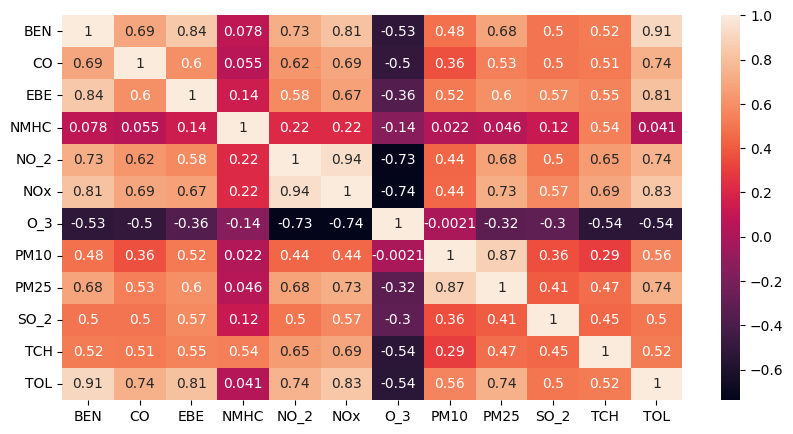

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(weekly_data.corr(), annot = True, cmap='coolwarm')
plt.show()

NMHC and PM10 don't have a large effect on the value of Carbon Monoxide, as their correlation is low. Let's drop these and go with the other gases.

In [ ]:
corr_weekly = weekly_data.drop(['NMHC', 'PM10'], axis = 1)
corr_weekly.head()

,BEN,CO,EBE,NO_2,NOx,O_3,PM25,SO_2,TCH,TOL
2001-01-07,0.300778,0.000609,0.634709,22.724072,29.141138,32.513593,7.111696,8.999102,0.001360,2.664012
2001-01-14,0.723155,0.000895,1.505188,50.246667,96.241250,13.021190,13.771030,15.050119,0.001530,9.041607
2001-01-21,0.359709,0.000765,0.809573,31.454524,59.776762,22.960567,10.989644,11.679345,0.001447,4.085045
2001-01-28,0.245893,0.000602,0.520044,19.118274,32.080833,34.955595,7.793673,9.036905,0.001362,1.797560
2001-02-04,0.527911,0.000896,1.107875,46.180714,100.565164,18.813333,15.449894,16.739048,0.001536,5.555465


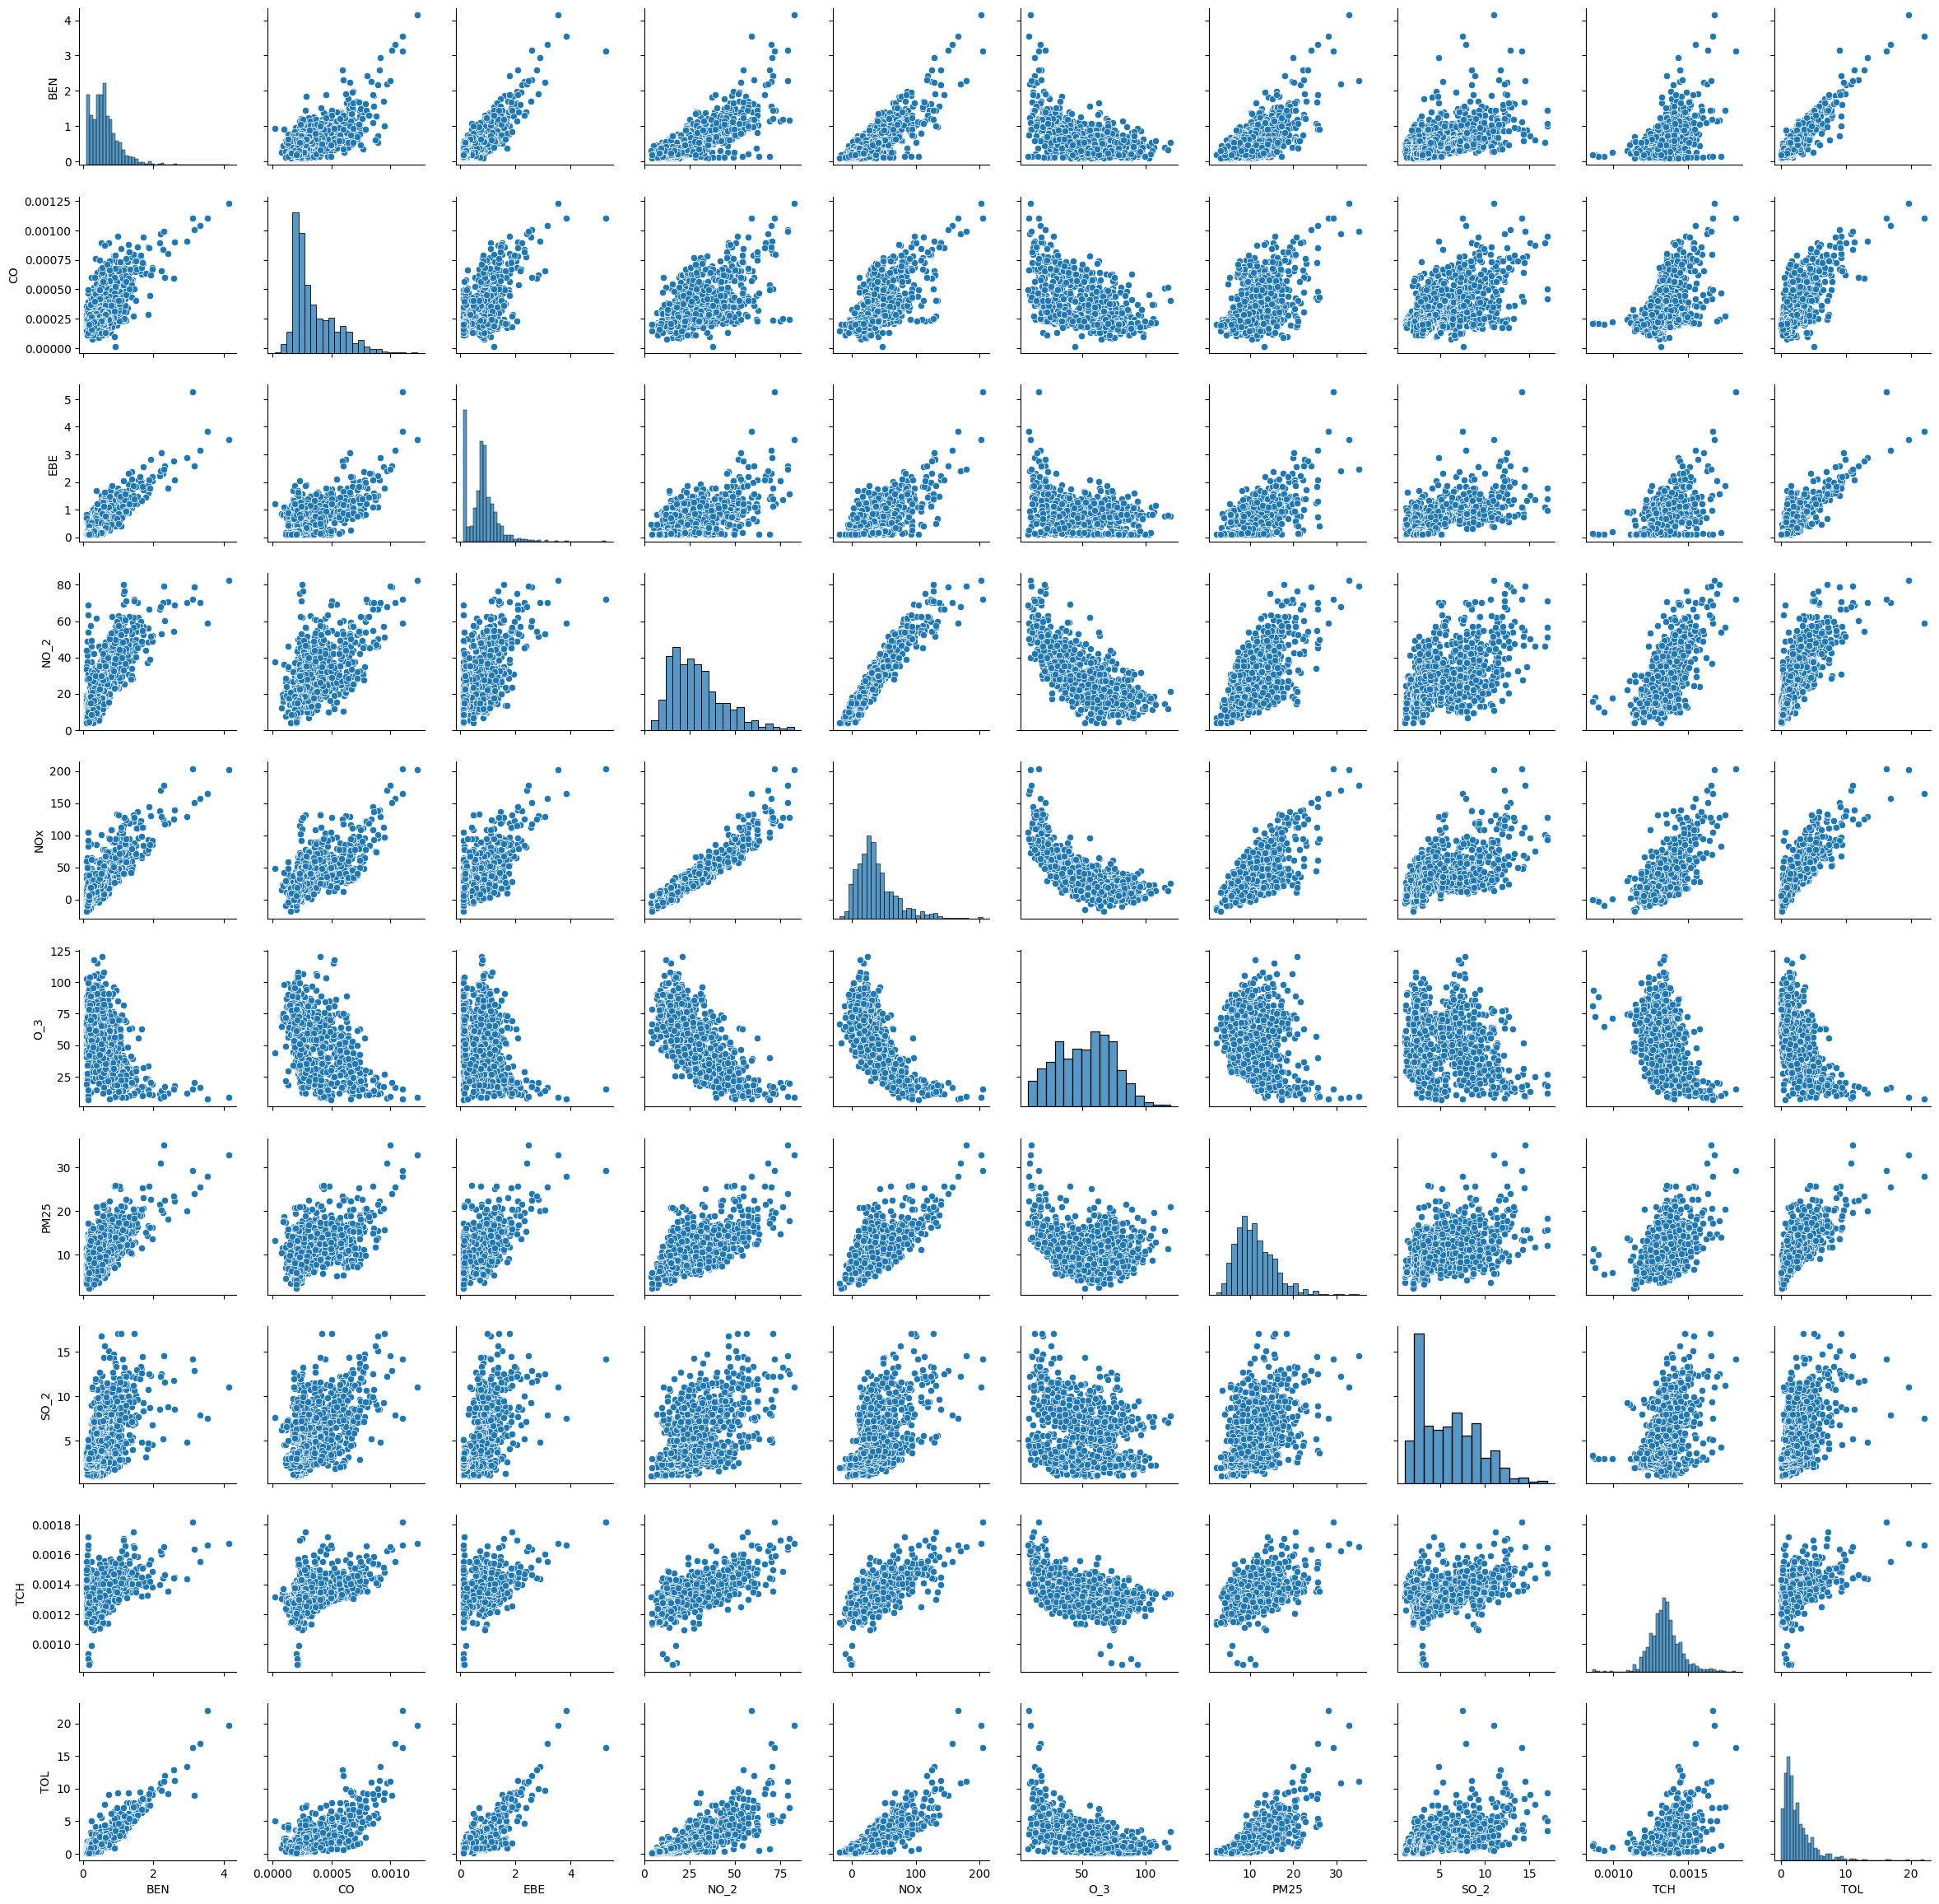

In [ ]:
g = sns.pairplot(corr_weekly)
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.2, wspace=0.2)

# display the plot
plt.show()

In [ ]:
#Creating lag variables
dataframe = pd.DataFrame()
#On a weekly basis, the ideal number of lags should be 54.
for i in range(54, 0, -1):
    dataframe['t-' + str(i)] = corr_weekly.CO.shift(i)
#Combine the lagged dataframe with the original
lagged_data = pd.concat([corr_weekly, dataframe], axis = 1)
lagged_data.dropna(inplace = True)
lagged_data

,BEN,CO,EBE,NO_2,NOx,O_3,PM25,SO_2,TCH,TOL,...,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
2002-01-20,2.944489,0.000912,2.870541,70.213333,129.188809,11.912440,19.997153,4.871488,0.001434,13.312385,...,0.000771,0.000742,0.000859,0.001103,0.001040,0.000905,0.000804,0.001229,0.000629,0.000837
2002-01-27,1.974905,0.000685,2.041222,48.908036,86.032951,18.923988,16.211731,4.564702,0.001382,9.440284,...,0.000742,0.000859,0.001103,0.001040,0.000905,0.000804,0.001229,0.000629,0.000837,0.000912
2002-02-03,2.176837,0.000894,2.236815,66.617559,138.590833,11.280952,21.587195,8.541071,0.001399,10.015852,...,0.000859,0.001103,0.001040,0.000905,0.000804,0.001229,0.000629,0.000837,0.000912,0.000685
2002-02-10,1.819524,0.000634,1.779583,37.090595,73.203274,23.403690,14.343423,4.128155,0.001325,7.442798,...,0.001103,0.001040,0.000905,0.000804,0.001229,0.000629,0.000837,0.000912,0.000685,0.000894
2002-02-17,1.773452,0.000637,1.453393,44.074583,74.879842,23.569226,15.165010,3.147321,0.001389,6.771667,...,0.001040,0.000905,0.000804,0.001229,0.000629,0.000837,0.000912,0.000685,0.000894,0.000634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-08,0.303534,0.000183,0.139110,14.825774,20.393173,68.066266,8.080165,3.686190,0.001175,0.887483,...,0.000291,0.000286,0.000244,0.000228,0.000238,0.000226,0.000202,0.000197,0.000206,0.000180
2018-04-15,0.234524,0.000158,0.100595,8.361488,10.259488,78.071429,6.124309,3.085000,0.001150,0.304762,...,0.000286,0.000244,0.000228,0.000238,0.000226,0.000202,0.000197,0.000206,0.000180,0.000183
2018-04-22,0.308051,0.000220,0.215782,16.257083,20.917614,72.865464,13.686957,3.819524,0.001236,1.041671,...,0.000244,0.000228,0.000238,0.000226,0.000202,0.000197,0.000206,0.000180,0.000183,0.000158
2018-04-29,0.222024,0.000209,0.130952,14.665060,18.345801,70.215075,13.155113,3.608810,0.001224,0.880952,...,0.000228,0.000238,0.000226,0.000202,0.000197,0.000206,0.000180,0.000183,0.000158,0.000220


In [ ]:
#Slice the data into train and test
#The testing slice is for the final 26 weeks of the dataset
train = lagged_data.loc['2002-01-20' : '2017-11-05']
test = lagged_data.loc['2017-11-12' : '2018-05-06']
x_test = test.loc[:, test.columns != 'CO']
y_test = test['CO']
x_train = train.loc[:, train.columns != 'CO']
y_train = train['CO']

In [ ]:
print("Training model...")
reg_forest = RandomForestRegressor(n_estimators = 100, random_state = 42)
rfe_weekly = RFE(estimator = reg_forest, n_features_to_select = 13)
fit_weekly = rfe_weekly.fit(x_train, y_train)
predictions = fit_weekly.predict(x_test)

Training model...


In [ ]:
correct = np.array(y_test)
sumvalue = np.sum(correct)
mape = np.sum(np.abs((correct - predictions))) / sumvalue * 100
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 90.47 %.


In [ ]:
#calculating bias
errors = [correct[i] - predictions[i] for i in range(len(correct))]
bias = sum(errors) * 1.0/len(correct)
print('Bias: %f' % bias)

Bias: -0.000009


Our bias is very close to 0, however from the negative sign, we have slightly over forecast.

In [ ]:
mae = mean_absolute_error(errors, predictions)
print('MAE: %f' %mae)

MAE: 0.000273


In [ ]:
mse = mean_squared_error(errors, predictions)
print('MSE: %f' % mse)

MSE: 0.000000


In [ ]:
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.000282


In [ ]:
print(r2_score(y_test, predictions))

0.8162267258346344


In [ ]:
#As the predictions are in array,  we need to convert them to a DataFrame in order for the plot_series function to read it
predicted_df = pd.DataFrame(predictions)
predicted_df['date'] = y_test.index
predicted_df['date'] = pd.to_datetime(predicted_df.date, infer_datetime_format = True)
predicted_df.index = predicted_df['date']
predicted_df = predicted_df.drop(['date'], axis = 1)
predicted_df.index = pd.to_datetime(predicted_df.index)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='Date', ylabel='CO Levels (μgm-3)'>)

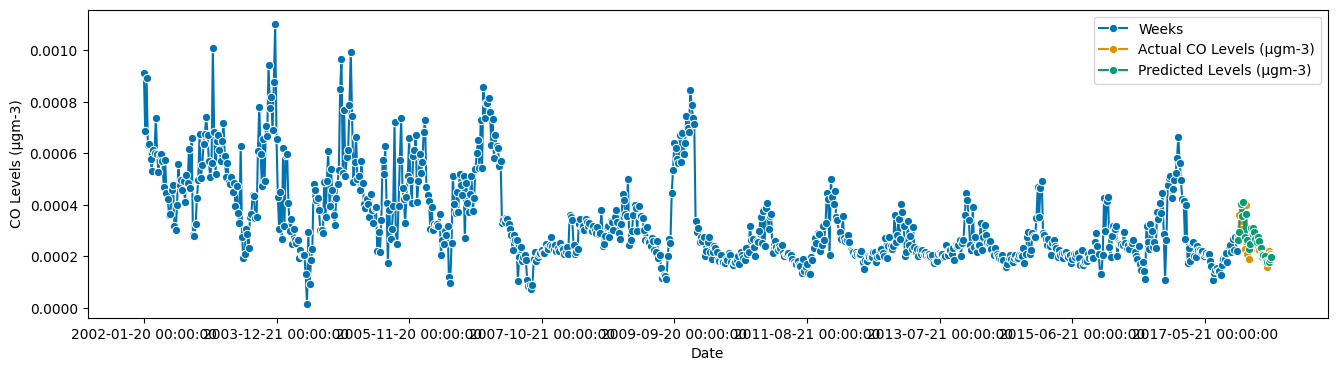

In [ ]:
plot_series(y_train, y_test, predicted_df, x_label = 'Date', y_label = 'CO Levels (μgm-3)', labels = ['Weeks', 'Actual CO Levels (μgm-3)', 'Predicted Levels (μgm-3)'])

# Monthly Resampling

In [ ]:
monthly_data = data_imputed.resample('M').mean()
monthly_data.head()

,BEN,CO,EBE,NMHC,NO_2,NOx,O_3,PM10,PM25,SO_2,TCH,TOL
date,,,,,,,,,,,,
2001-01-31,0.414322,0.000732,0.884759,0.141494,32.272773,58.505876,25.748446,17.363149,10.421379,11.735047,0.001433,4.459876
2001-02-28,0.643197,0.000834,1.298526,0.162946,40.763051,73.791451,28.087449,22.641414,12.176547,14.520818,0.001460,6.774207
2001-03-31,0.756143,0.000638,1.083559,0.099691,23.350578,34.725380,41.876160,19.475914,9.912690,10.301734,0.001368,3.866658
2001-04-30,0.735552,0.000639,1.012272,0.107500,24.128681,31.726316,53.294358,22.534792,10.456545,10.640417,0.001330,2.824384
2001-05-31,0.983992,0.000597,1.280000,0.110753,34.736183,42.970296,54.114328,26.182419,11.741705,10.941640,0.001367,4.227191


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CO'>)

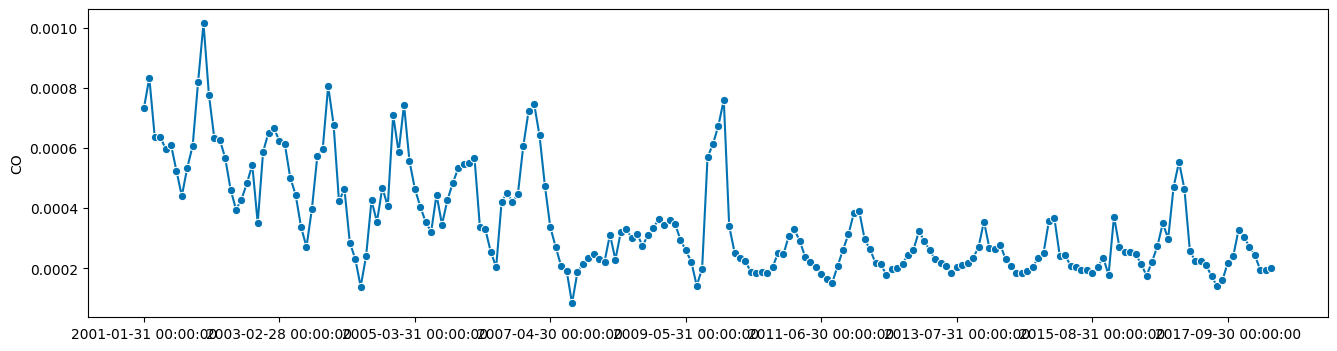

In [ ]:
plot_series(monthly_data['CO'])

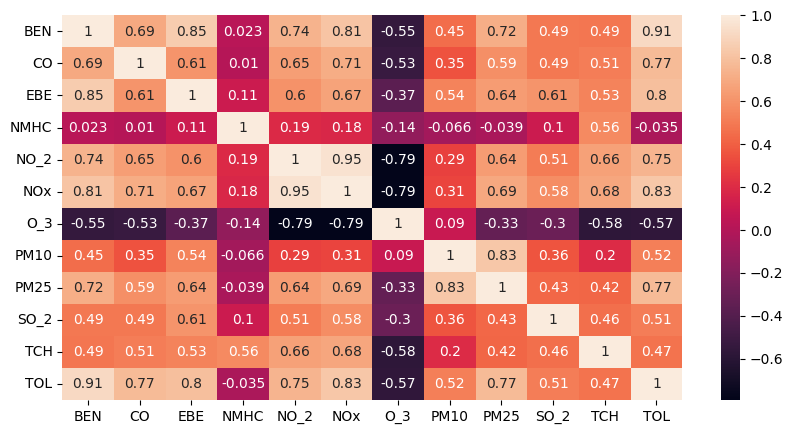

In [ ]:
fig=plt.figure(figsize=(10,5)) 
sns.heatmap(monthly_data.corr(), annot = True, cmap='coolwarm')
plt.show()

In [ ]:
#Select highly correlated columns
relevant_monthly = monthly_data.drop(['NMHC', 'PM10'], axis = 1)
relevant_monthly

,BEN,CO,EBE,NO_2,NOx,O_3,PM25,SO_2,TCH,TOL
2001-01-31,0.414322,0.000732,0.884759,32.272773,58.505876,25.748446,10.421379,11.735047,0.001433,4.459876
2001-02-28,0.643197,0.000834,1.298526,40.763051,73.791451,28.087449,12.176547,14.520818,0.001460,6.774207
2001-03-31,0.756143,0.000638,1.083559,23.350578,34.725380,41.876160,9.912690,10.301734,0.001368,3.866658
2001-04-30,0.735552,0.000639,1.012272,24.128681,31.726316,53.294358,10.456545,10.640417,0.001330,2.824384
2001-05-31,0.983992,0.000597,1.280000,34.736183,42.970296,54.114328,11.741705,10.941640,0.001367,4.227191
...,...,...,...,...,...,...,...,...,...,...
2018-01-31,0.578258,0.000272,0.263169,29.869153,56.104371,31.226520,8.583847,4.233548,0.001218,2.048348
2018-02-28,0.547687,0.000244,0.196744,28.314673,43.036745,42.487002,7.843136,4.010179,0.001207,1.377709
2018-03-31,0.327136,0.000194,0.133265,11.387715,15.128316,70.995515,4.741493,3.308548,0.001150,0.547322
2018-04-30,0.266314,0.000193,0.143503,13.197750,17.072084,72.289810,10.009485,3.547944,0.001196,0.742914


In [ ]:
#Creating lag variables
dataframe = pd.DataFrame()
for i in range(12, 0, -1):
    dataframe['t-' + str(i)] = relevant_monthly.CO.shift(i)
lagged_monthly = pd.concat([relevant_monthly, dataframe], axis = 1)
lagged_monthly.dropna(inplace = True)

In [ ]:
#Adding seasonal variables
train1 = lagged_monthly.loc['2002-01-31' : '2017-11-30']
test1 = lagged_monthly.loc['2017-12-31' : '2018-05-31']
x_test1 = test1.loc[:, test1.columns != 'CO']
y_test1 = test1['CO']
x_train1 = train1.loc[:, train1.columns != 'CO']
y_train1 = train1['CO']

In [ ]:
print("Training model...")
monthly_reg = RandomForestRegressor(n_estimators = 100, random_state = 42)
monthly_rfe = RFE(estimator = monthly_reg, n_features_to_select = 9)
monthly_fit = monthly_rfe.fit(x_train1, y_train1)
monthly_predictions = monthly_fit.predict(x_test1)

Training model...


In [ ]:
import numpy as np
correct1 = np.array(y_test1)
sumvalue1 = np.sum(correct1)
mape1 = np.sum(np.abs((correct1 - monthly_predictions))) / sumvalue1 * 100
accuracy1 = 100 - mape1
print('Accuracy:', round(accuracy1, 2), '%.')

Accuracy: 83.73 %.


In [ ]:
#calculating bias
monthly_errors = [correct1[i] - monthly_predictions[i] for i in range(len(correct1))]
monthly_bias = sum(monthly_errors) * 1.0/len(correct1)
print('Bias: %f' % monthly_bias)

Bias: -0.000037


The monthly data is more biased than the weekly data. This is to be expected as we are using a lot of averages.

In [ ]:
df1 = pd.DataFrame(monthly_predictions)
df1['date'] = y_test1.index
df1['date'] = pd.to_datetime(df1.date, infer_datetime_format = True)
df1.index = df1['date']
df1 = df1.drop(['date'], axis = 1)
df1.index = pd.to_datetime(df1.index)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CO'>)

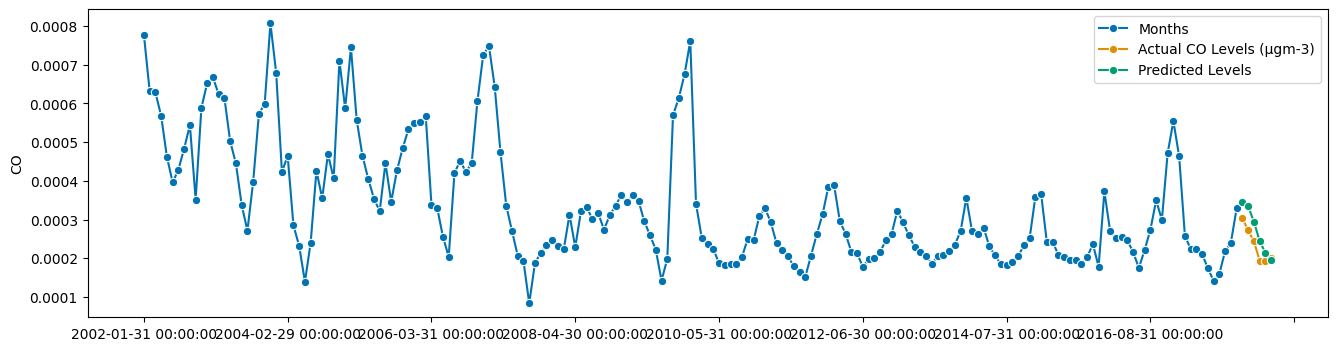

In [ ]:
plot_series(y_train1, y_test1, df1, labels = ['Months', 'Actual CO Levels (μgm-3)', 'Predicted Levels'])

# Quarterly Resampling

In [ ]:
quarterly_data = data_imputed.resample('Q').mean()
quarterly_data.head()

,BEN,CO,EBE,NMHC,NO_2,NOx,O_3,PM10,PM25,SO_2,TCH,TOL
date,,,,,,,,,,,,
2001-03-31,0.603354,0.000732,1.082053,0.133766,31.840792,55.068738,32.034147,19.734104,10.792388,12.108208,0.001419,4.975798
2001-06-30,0.926514,0.000616,1.225781,0.116255,31.650980,39.580493,56.483128,29.200238,12.490377,10.989826,0.001352,3.828098
2001-09-30,0.854173,0.000500,1.068416,0.112409,32.734728,38.484621,56.109720,35.670643,14.138307,11.300172,0.001366,4.129965
2001-12-31,1.919570,0.000810,1.948412,0.157083,47.244264,95.405399,19.007608,32.020005,17.654523,10.986782,0.001447,9.894141
2002-03-31,1.636401,0.000681,1.566520,0.144306,49.004250,80.463205,24.755471,26.402093,15.522001,3.996884,0.001375,7.000048


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CO'>)

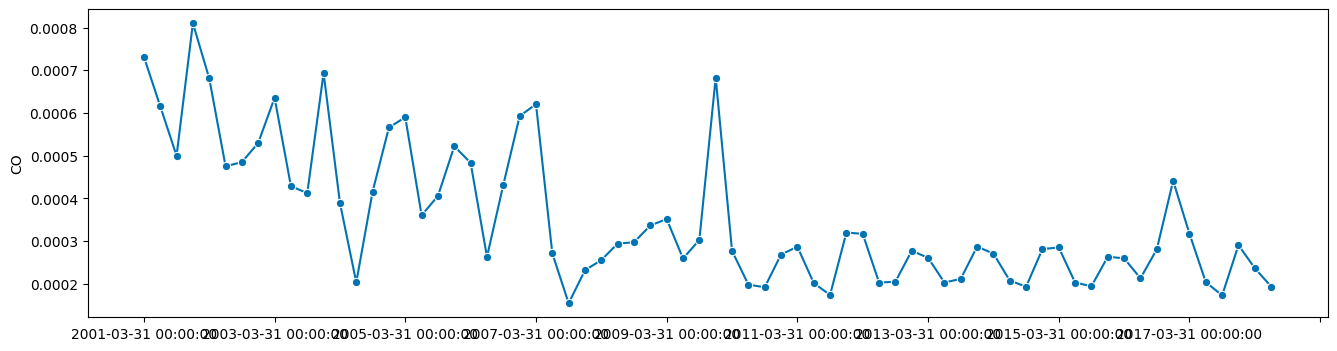

In [ ]:
plot_series(quarterly_data['CO'])

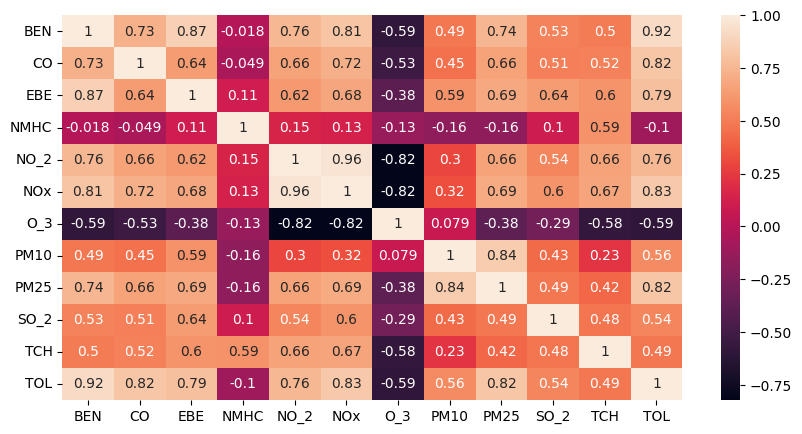

In [ ]:
fig= plt.figure(figsize=(14,6)) 
sns.heatmap(quarterly_data.corr(), annot = True, ax = ax)
plt.show()

In [ ]:
relevant_quarterly = quarterly_data.drop(['NMHC'], axis = 1)
relevant_quarterly.head()

,BEN,CO,EBE,NO_2,NOx,O_3,PM10,PM25,SO_2,TCH,TOL
2001-03-31,0.603354,0.000732,1.082053,31.840792,55.068738,32.034147,19.734104,10.792388,12.108208,0.001419,4.975798
2001-06-30,0.926514,0.000616,1.225781,31.650980,39.580493,56.483128,29.200238,12.490377,10.989826,0.001352,3.828098
2001-09-30,0.854173,0.000500,1.068416,32.734728,38.484621,56.109720,35.670643,14.138307,11.300172,0.001366,4.129965
2001-12-31,1.919570,0.000810,1.948412,47.244264,95.405399,19.007608,32.020005,17.654523,10.986782,0.001447,9.894141
2002-03-31,1.636401,0.000681,1.566520,49.004250,80.463205,24.755471,26.402093,15.522001,3.996884,0.001375,7.000048


In [ ]:
#Creating lag variables
dataframe = pd.DataFrame()
for i in range(4, 0, -1):
    dataframe['t-' + str(i)] = relevant_quarterly.CO.shift(i)
lagged_quarterly = pd.concat([relevant_quarterly, dataframe], axis = 1)
lagged_quarterly.dropna(inplace = True)

In [ ]:
quarter_train = lagged_quarterly.loc['2002-03-31' : '2016-12-31']
quarter_test = lagged_quarterly.loc['2017-03-31' : '2018-03-31']
x_test2 = quarter_test.loc[:, quarter_test.columns != 'CO']
y_test2 = quarter_test['CO']
x_train2 = quarter_train.loc[:, quarter_train.columns != 'CO']
y_train2 = quarter_train['CO']

In [ ]:
quarterly_reg = RandomForestRegressor(n_estimators = 100, random_state = 42)
quarterly_rfe = RFE(estimator = quarterly_reg, n_features_to_select = 9)
quarterly_fit = quarterly_rfe.fit(x_train2, y_train2)
quarterly_predictions = quarterly_fit.predict(x_test2)

In [ ]:
correct2 = np.array(y_test2)
sumvalue2 = np.sum(correct2)
mape = np.sum(np.abs((correct2 - quarterly_predictions))) / sumvalue2 * 100
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 83.93 %.


In [ ]:
#calculating bias
quarterly_errors = [correct2[i] - quarterly_predictions[i] for i in range(len(correct2))]
quarterly_bias = sum(quarterly_errors) * 1.0/len(correct2)
print('Bias: %f' % quarterly_bias)

Bias: -0.000025


In [ ]:
quarterly_df = pd.DataFrame(quarterly_predictions)
quarterly_df['date'] = y_test2.index
quarterly_df['date'] = pd.to_datetime(quarterly_df.date, infer_datetime_format = True)
quarterly_df.index = quarterly_df['date']
quarterly_df = quarterly_df.drop(['date'], axis = 1)
quarterly_df.index = pd.to_datetime(quarterly_df.index)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='CO'>)

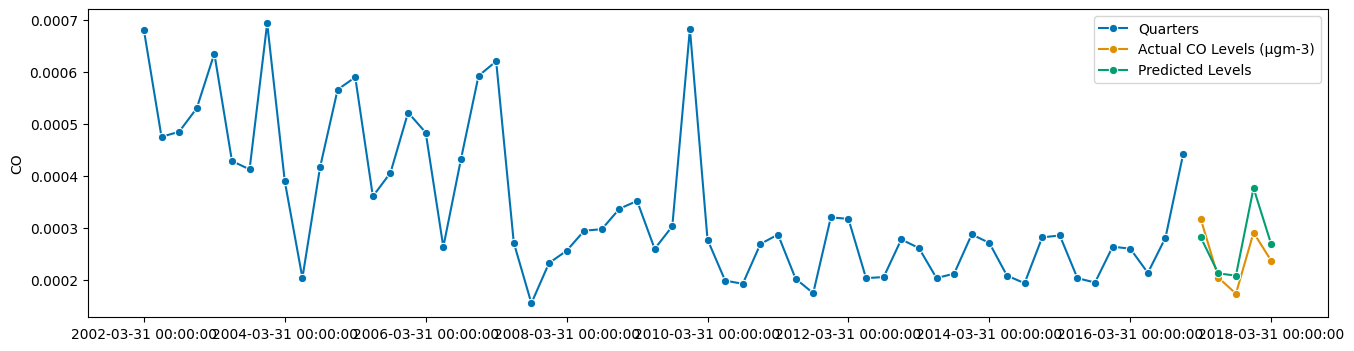

In [ ]:
plot_series(y_train2, y_test2, quarterly_df, labels = ['Quarters', 'Actual CO Levels (μgm-3)', 'Predicted Levels'])

Weekly Resampling has the highest prediction accuracy of all the timeframes.

In [ ]:
import pickle
weeklymodel = 'best_model.sav'
pickle.dump(fit_weekly, open(weeklymodel, 'wb'))